#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Lab 7: Feature Engineering - Creating Synthetic Features
**Learning Objectives:**
  * Gain more experience with the `LinearRegressor` class in TensorFlow by using it to predict median housing price, at the granularity of city blocks
  * Use a validation data set and test set to make sure that our model will generalize and is not overfitting the training data.
  * Use test data only after tuning hyperparameters as a measure of how the model will generalize to new data
  * Create synthetic features from the existing features (e.g., taking a ratio of two other features)
  * More practice with feature transformations including identifying and clipping (removing) outliers out of the input data to obtain the best model


### Standard Set-up

We begin with the same set-up as in the last lab.

In [0]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error. You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15


Read the data and randomize the order.

In [0]:
california_housing_dataframe = pd.read_csv("https://storage.googleapis.com/ml_universities/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00,17000.00
mean,-119.56,35.63,28.59,2643.66,539.41,1429.57,501.22,3.88,207300.91
std,2.01,2.14,12.59,2179.95,421.50,1147.85,384.52,1.91,115983.76
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,14999.00
25%,-121.79,33.93,18.00,1462.00,297.00,790.00,282.00,2.57,119400.00
50%,-118.49,34.25,29.00,2127.00,434.00,1167.00,409.00,3.54,180400.00
75%,-118.00,37.72,37.00,3151.25,648.25,1721.00,605.25,4.77,265000.00
max,-114.31,41.95,52.00,37937.00,6445.00,35682.00,6082.00,15.00,500001.00


##Prepare Features

As our learning models get more sophisticated we will want to do some computation on the features and even generate new features from the existing features. You will change this later in the lab. For now this method will just make a copy of the portion of the dataframe we plan to use, and re-scale the median-house value (to make it a bit easier to work with).

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  return processed_features

###Divide the provided data for training our model into a training and validation set

As in the last lab we use the first 14000 examples (after randomization) for the ***training set*** and the remaining 3000 examples for the ***validation set***.

In [0]:
training_examples = prepare_features(california_housing_dataframe.head(14000))
validation_examples = prepare_features(california_housing_dataframe.tail(3000))

### Load the Test Data

As in the last lab we load the test data from [here](https://storage.googleapis.com/ml_universities/california_housing_test.csv).

In [0]:
california_housing_test_data = pd.read_csv(
    "https://storage.googleapis.com/ml_universities/california_housing_test.csv",
    sep=",")

test_examples = prepare_features(california_housing_test_data)

### Compute Loss

Here is a simple method to compute the loss on the given input function and targets.

In [0]:
def compute_loss(model, input_fn, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    model: the trained model to use for making the predictions.
    input_fn: the input_fn to use to make the predictions.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets.
  """      
  predictions = list(model.predict(input_fn=input_fn))
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

### Setting Up the Feature Columns and Input Function for TensorFlow
As in the last lab we define `input_fn` to create a real-valued feature for each provided
numerical column, and then define `train_input_fn` to use the training data, `eval_input_fn` to use the validation data, and `test_input_fn` to use the test data.

In [0]:
CATEGORICAL_COLUMNS = []
NUMERICAL_COLUMNS = ["latitude", "longitude", "housing_median_age", 
                     "total_rooms", "total_bedrooms", "population",
                     "households", "median_income"]
def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  return input_fn(training_examples)

def eval_input_fn():
  return input_fn(validation_examples)

def test_input_fn():
  return input_fn(test_examples)

### Functions to help visualize our results

We will use our functions from the last lab to generate a calibration plot and learning curve (with both training and validation losses).

In [0]:
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])
  
def plot_learning_curve(training_losses, validation_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of training losses to plot.
    validation_losses: a list of validation losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses, label="training")
  plt.plot(validation_losses, label="validation")
  plt.legend(loc=1)

### Defining the features, linear regression model, and function to train the model

These functions are just like the last lab except now we include all of the available numerical features.

In [0]:
NUMERICAL_FEATURES = ["latitude", "longitude", "housing_median_age", 
                     "total_rooms", "total_bedrooms", "population",
                     "households"]
LABEL = "median_income"

def construct_feature_columns():
  """Construct TensorFlow Feature Columns for features.
  
  Returns:
    A set of feature columns.
  """
  feature_set = set([tf.contrib.layers.real_valued_column(feature) 
                     for feature in NUMERICAL_FEATURES])
  return feature_set

def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate.
    
  Returns:
    A linear regressor created with the given parameters.
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train.
    steps: A non-zero `int`, the total number of training steps.
    
  Returns:
    The trained regressor.
  """
  # In order to see how the model evolves as we train it, we divide the
  # steps into periods and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.  We store the training and validation losses so we can
  # generate a learning curve.
  print "Training model..."
  training_losses = []
  validation_losses = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps.
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)
    
    # Compute the loss between the predictions and the correct labels, append
    # the training and validation loss to the list of losses used to generate
    # the learning curve after training is complete and print the current
    # training loss.
    training_loss = compute_loss(linear_regressor, train_input_fn,
                                 training_examples[LABEL])
    validation_loss = compute_loss(linear_regressor, eval_input_fn,
                                   validation_examples[LABEL])
    training_losses.append(training_loss) 
    validation_losses.append(validation_loss) 
    print "  Training loss after period %02d : %0.3f" % (period, training_loss)
      
  # Now that training is done print the final training and validation losses.    
  print "Final Training Loss (RMSE): %0.3f" % training_loss
  print "Final Validation Loss (RMSE): %0.3f" % validation_loss 
  
  # Generate a figure with the learning curve on the left and a
  # calibration plot on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses, validation_losses)
  
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0) 
  plt.title("Calibration Plot on Validation Data")
  validation_predictions = np.array(list(linear_regressor.predict(
      input_fn=eval_input_fn)))
  make_calibration_plot(validation_predictions, validation_examples[LABEL])
   
  return linear_regressor

### Training a model with one feature.

In the last lab, you trained a model to predict the `median_house_value` from a single feature. Before we explore what can be done by introducing additional features, let's just train a good model to use a single feature.  Feel free to change the below, but as is it should give a pretty good result (given the constraint of using a single feature).

Training model...
  Training loss after period 00 : 201.995
  Training loss after period 01 : 167.722
  Training loss after period 02 : 135.846
  Training loss after period 03 : 108.500
  Training loss after period 04 : 89.911
  Training loss after period 05 : 85.096
  Training loss after period 06 : 84.580
  Training loss after period 07 : 84.231
  Training loss after period 08 : 84.081
  Training loss after period 09 : 84.041
Final Training Loss (RMSE): 84.041
Final Validation Loss (RMSE): 82.378


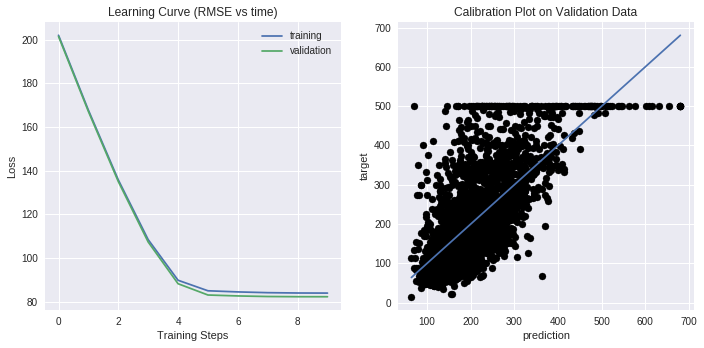

In [0]:
NUMERICAL_FEATURES = ["median_income"]
LABEL = "median_house_value"

LEARNING_RATE = 0.01
STEPS = 1750


linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

Once you've adjusted the hyperparameters (if you'd like to see if you can reduce the validation loss), let's check the loss on the test data.

In [0]:
print "loss on test data is", compute_loss(
    linear_regressor, test_input_fn, test_examples[LABEL])

loss on test data is 83.773585811


## Task 1: Introduce Synthetic Features (1 Point)
Both the total_rooms and population features count totals for a given city block.
But what if one city block were more densely populated than another? Then just using `total_rooms` and `population` directly might not be very useful.  Instead what we really want is the **quadratic feature** obtain by dividing `total_rooms` by the `population` to give the average number of rooms per person for that city block.

We've got you started by creating a feature called rooms_per_person.  Create others, and use them along with whatever other features you think are useful to train a model.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new DataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  # Add your synthetic features here. We've got you started by defining 
  # rooms_per_person
  processed_features["rooms_per_person"] = (
    dataframe["total_rooms"] / dataframe["population"])

  processed_features["rooms_per_household"] = (
      dataframe["total_rooms"] / dataframe["households"])
  processed_features["bedrooms_per_household"] = (
      dataframe["total_bedrooms"] / dataframe["households"])
  return processed_features

# Generate the training, validation and test examples
training_examples = prepare_features(california_housing_dataframe.head(14000))
validation_examples = prepare_features(california_housing_dataframe.tail(3000))
test_examples = prepare_features(california_housing_test_data)

validation_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,rooms_per_household,bedrooms_per_household
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00
mean,-119.59,35.66,28.85,2643.75,540.74,1434.38,504.20,3.89,207.54,1.97,5.40,1.09
std,2.01,2.15,12.67,2137.21,426.19,1179.61,390.56,1.86,114.69,0.90,1.92,0.33
min,-124.30,32.56,1.00,11.00,6.00,13.00,4.00,0.54,15.00,0.18,0.85,0.55
25%,-121.82,33.93,18.00,1477.00,301.75,791.00,286.75,2.58,120.77,1.54,4.49,1.00
50%,-118.53,34.27,29.00,2119.50,431.00,1168.00,406.00,3.59,181.65,1.96,5.26,1.05
75%,-118.01,37.71,37.00,3150.00,651.25,1746.00,609.00,4.78,265.18,2.31,6.06,1.10
max,-114.57,41.95,52.00,32627.00,6445.00,28566.00,6082.00,15.00,500.00,22.58,52.69,9.70


Since we added new features, we need to add them to `NUMERICAL_COLUMNS` so that they are included in the dictionary created by `input_fn`.

In [0]:
# Add any other synthetic features you create to this list.
NUMERICAL_COLUMNS = ["latitude", "longitude", "housing_median_age", 
                     "total_rooms", "total_bedrooms", "population",
                     "households", "median_income", "rooms_per_person",
                    "rooms_per_household", "bedrooms_per_household"]


##Task 2 -- Add a Clip Feature Transformation (1 point)

Recall that there are two characteristics we'd like of numerical features when used together to train a linear model:
* The range of the features is roughly the same.
* To the extent possible the histogram of the features kind of resembles a bell curve.  Sometimes the data will fit this very well and other times it won't.

Below are the methods to perform linear scaling and log scaling.  For this data set it will also be useful to have a feature transformation to cap the features to within a minimum and/or maximum value.  Most likely you will want to then linearly scale or log scale the feature after clipping it.

In [0]:
# Linearly rescales to the range [0, 1]
def linear_scale(series):
  min_val = series.min()
  max_val = series.max()
  scale = 1.0 * (max_val - min_val)
  return series.apply(lambda x:((x - min_val) / scale))

# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Clip all features to given min and max
def clip(series, clip_to_min, clip_to_max):
  # You need to modify this to actually do the clipping versus just returning
  # the series unchanged.
  return series.apply(lambda x: np.clip(x, clip_to_min, clip_to_max))

You can use this function to draw a histogram to help decide what kind of scaling is best to use for `households` and also to confirm your implementation of `clip` works as you intended.

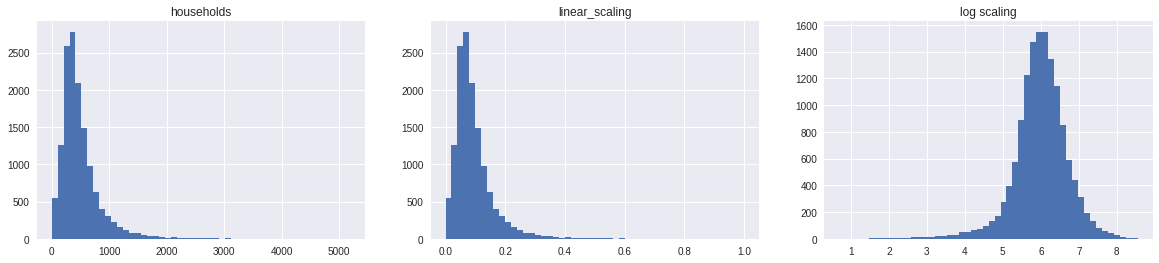

In [0]:
clip_min = -np.inf
clip_max = np.inf

def draw_histograms(dataframe, feature_name,
                    clip_min = -np.inf, clip_max = np.inf):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = dataframe[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(
      clip(dataframe[feature_name], clip_min, clip_max))
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(dataframe[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)
  
draw_histograms(training_examples, 'households')

Now let's clip between 0 and 1000 before scaling.


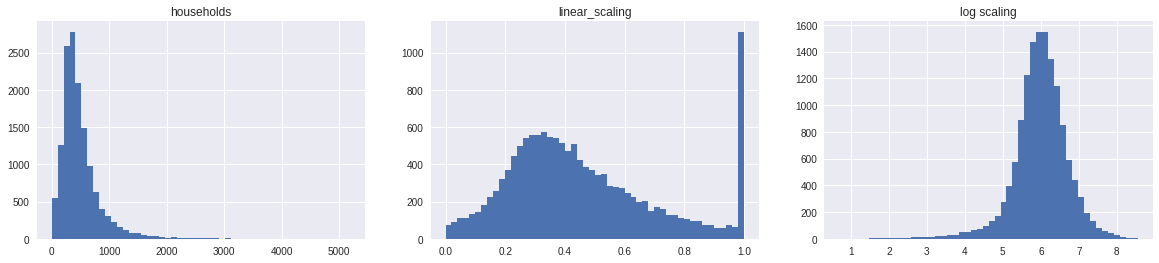

In [0]:
print "Now let's clip between 0 and 1000 before scaling."

draw_histograms(training_examples, 'households', 0, 1000)

The leftmost histogram is unchanged since that just shows the raw feature.  You should see a very visible change when you clip the feature before applying linear scaling. As you will often (but not always) find, for this particular feature log scaling worked well without the need to first clip the data.

**Run the above code with features other than `households` to help decide what feature normalization to use for each feature.**  Feel free to duplicate the code box that calls `draw_histogram` if you'd like to show the histograms for multiple features.

## Task 3: Train the Best Model You Can (3 points)

We expect you to take some time exploring the feature transformations and hyperparameters.

Select any number of the provided features, create synthetic features you think will be informative, and modify the hyperparmaters to get a better model. You will want to edit preprocess_features to do some feature normalization like you saw in the [Using Multiple Numerical Features and Feature Scaling](https://colab.research.google.com/notebook#fileId=/v2/external/notebooks/intro_to_ml_semester_course/Lab_3__Using_Multiple_Numerical_Features_and_Feature_Scaling.ipynb). See how well you are able to do.

**DO NOT APPLY ANY ADDITIONAL FEATURE TRANSFORMATION TO THE TARGET `median_price` since that would change the scale for RMSE.**

* Summarize the changes you made that were the most important.
* Once you find a model, try training 20 times more steps.  Does overfitting occur if you do that?


In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()
  
  # Modifying median_house_value to be in scale of $1000.  So a value of 14.0
  # will correspond to $14,000.  This will make it a bit easier to work with.
  processed_features["median_house_value"] /= 1000.0
  
  # Perform your feature scaling here
  
  
  # Add your synthetic features here. We've got you started by defining 
  # rooms_per_person
  processed_features["rooms_per_person"] = (
    dataframe["total_rooms"] / dataframe["population"])

  processed_features["rooms_per_household"] = (
      dataframe["total_rooms"] / dataframe["households"])
  processed_features["bedrooms_per_household"] = (
      dataframe["total_bedrooms"] / dataframe["households"])
  return processed_features

# Generate the training, validation and test examples
training_examples = prepare_features(california_housing_dataframe.head(14000))
validation_examples = prepare_features(california_housing_dataframe.tail(3000))
test_examples = prepare_features(california_housing_test_data)

training_examples.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,rooms_per_person,rooms_per_household,bedrooms_per_household
count,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00,14000.00
mean,-119.56,35.62,28.53,2643.65,539.13,1428.54,500.58,3.88,207.25,1.98,5.45,1.10
std,2.01,2.14,12.57,2189.07,420.50,1140.97,383.23,1.92,116.26,1.22,2.65,0.52
min,-124.35,32.54,1.00,2.00,1.00,3.00,1.00,0.50,15.00,0.02,0.89,0.33
25%,-121.78,33.93,18.00,1457.00,295.75,789.00,280.00,2.56,119.20,1.52,4.44,1.01
50%,-118.48,34.24,29.00,2129.00,434.00,1166.50,409.50,3.54,179.90,1.94,5.23,1.05
75%,-118.00,37.72,37.00,3151.25,648.00,1718.00,603.00,4.76,264.90,2.30,6.06,1.10
max,-114.31,41.95,52.00,37937.00,5471.00,35682.00,5189.00,15.00,500.00,55.22,141.91,34.07


Here's the method to train the model.  You'l need to fill in the features you want to use.

Training model...
  Training loss after period 00 : 96.544
  Training loss after period 01 : 82.328
  Training loss after period 02 : 79.197
  Training loss after period 03 : 78.589
  Training loss after period 04 : 78.444
  Training loss after period 05 : 78.390
  Training loss after period 06 : 78.360
  Training loss after period 07 : 78.339
  Training loss after period 08 : 78.323
  Training loss after period 09 : 78.311
Final Training Loss (RMSE): 78.311
Final Validation Loss (RMSE): 74.801


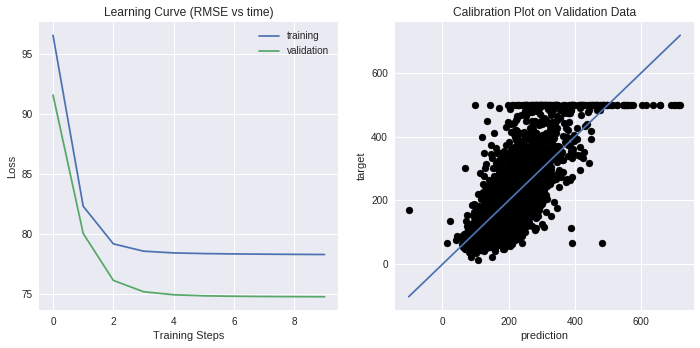

In [0]:
# Fill in the features you want to use
NUMERICAL_FEATURES = ["median_income", "rooms_per_household",
                     "bedrooms_per_household", "rooms_per_person"]
LABEL = "median_house_value"

LEARNING_RATE = .05
STEPS = 1500

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

You can look at the weights of the trained model.

In [0]:
# Let's also look at the weights and bias
for feature in NUMERICAL_FEATURES:
  print "weight for", feature, ":", linear_regressor.get_variable_value(
    "linear/" + feature + "/weight")[0]
print "bias:",  linear_regressor.get_variable_value("linear/bias_weight")

weight for median_income : [49.78812]
weight for rooms_per_household : [-31.815119]
weight for bedrooms_per_household : [54.538708]
weight for rooms_per_person : [43.895596]
bias: [41.331253]


Check the loss on the test data after you are done selecting the learning rate and number of steps to run.

In [0]:
print "loss on test data is", compute_loss(
    linear_regressor, test_input_fn, test_examples[LABEL])

loss on test data is 76.4054014163


Here's a code box for you to train your model with the same learning rate that worked best but to see what happens if you train it 20 times longer.

Training model...
  Training loss after period 00 : 78.274
  Training loss after period 01 : 78.271
  Training loss after period 02 : 78.271
  Training loss after period 03 : 78.271
  Training loss after period 04 : 78.271
  Training loss after period 05 : 78.271
  Training loss after period 06 : 78.271
  Training loss after period 07 : 78.271
  Training loss after period 08 : 78.271
  Training loss after period 09 : 78.271
Final Training Loss (RMSE): 78.271
Final Validation Loss (RMSE): 74.790


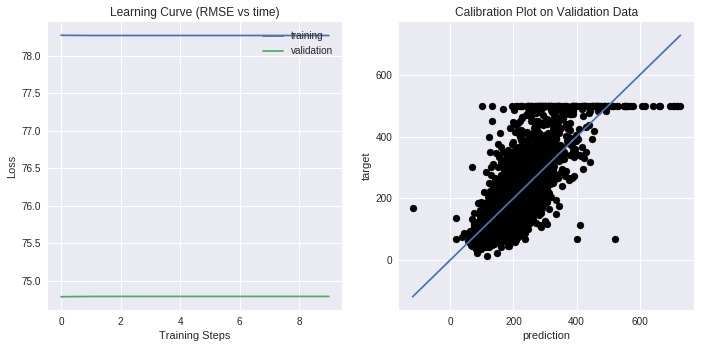

In [0]:
# Fill in the features you want to use
NUMERICAL_FEATURES = ["median_income", "rooms_per_household",
                     "bedrooms_per_household", "rooms_per_person"]
LABEL = "median_house_value"

LEARNING_RATE = .05
STEPS = 30000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

In [0]:
"""
Here's a place for you to answer these questions:


A) Summarize the changes you made that were the most important.

Adding the synthetic featues "rooms_per_house_hold" and "bedrooms_per_household"
and increasing the steps to 1500 were the most important.
Number of rooms and bedroom are things people look for when buying a house and
also impact the cost of the home. Increasing the steps helped train the model 
becuase it wouldn't break 80 RMSE before.


B) Once you find a model, try training 20 times more steps.  Does overfitting
   occur if you do that?

After training 20 more times there is graph loss. This appears to be overfit becuase the 
RMSE is higher than the training data's RMSE, especially when compared to before
training 20 times more steps.
"""